Loaded 6010 satellites
Best Tilt: 15°, Best Rotation: 240°


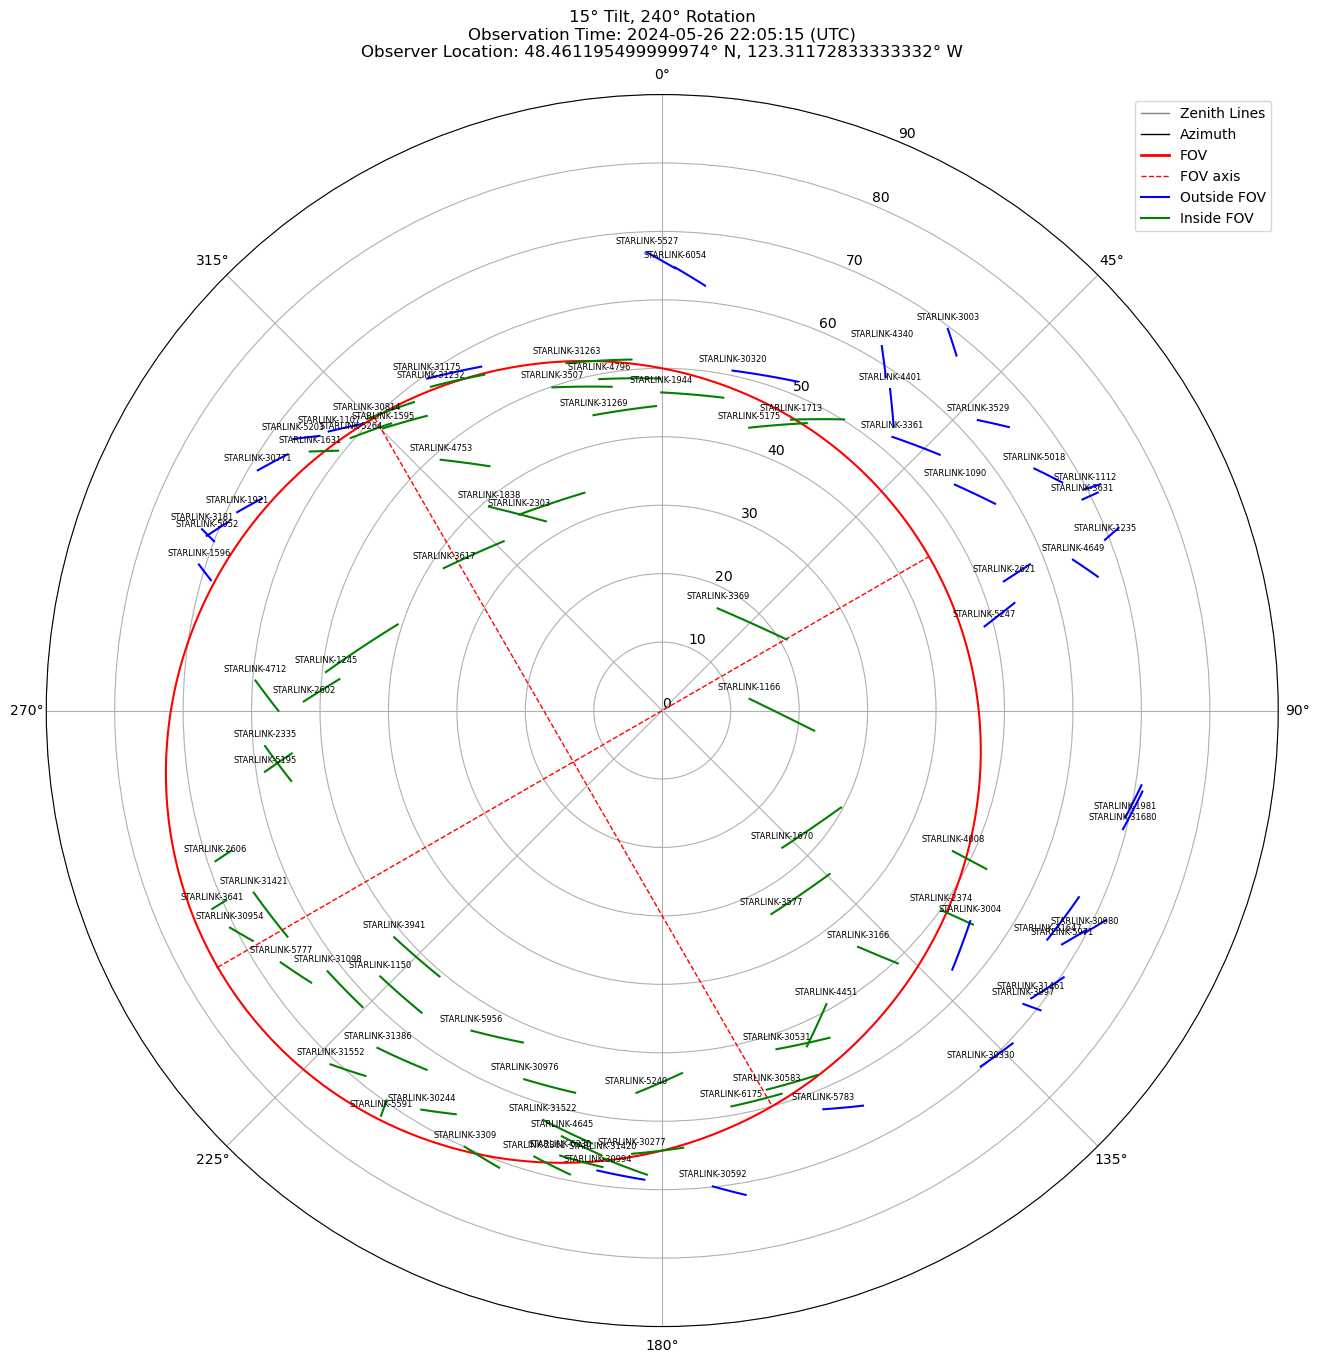

Satellites inside the FOV: ['STARLINK-1166', 'STARLINK-1150', 'STARLINK-1245', 'STARLINK-1631', 'STARLINK-1595', 'STARLINK-1713', 'STARLINK-1670', 'STARLINK-1944', 'STARLINK-1838', 'STARLINK-2335', 'STARLINK-2361', 'STARLINK-2374', 'STARLINK-2303', 'STARLINK-2606', 'STARLINK-2602', 'STARLINK-3309', 'STARLINK-3369', 'STARLINK-3166', 'STARLINK-3507', 'STARLINK-3617', 'STARLINK-3641', 'STARLINK-3577', 'STARLINK-4008', 'STARLINK-3941', 'STARLINK-4451', 'STARLINK-4645', 'STARLINK-4712', 'STARLINK-4753', 'STARLINK-4796', 'STARLINK-5195', 'STARLINK-5175', 'STARLINK-5240', 'STARLINK-5264', 'STARLINK-5591', 'STARLINK-5956', 'STARLINK-5777', 'STARLINK-6175', 'STARLINK-6230', 'STARLINK-30244', 'STARLINK-30277', 'STARLINK-30531', 'STARLINK-30583', 'STARLINK-30814', 'STARLINK-30954', 'STARLINK-30976', 'STARLINK-31098', 'STARLINK-31232', 'STARLINK-31263', 'STARLINK-31269', 'STARLINK-31522', 'STARLINK-31421', 'STARLINK-31420', 'STARLINK-31386', 'STARLINK-31552']


In [3]:
from skyfield.api import load, wgs84
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
import math

def load_data():
    stations_url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle'
    satellites = load.tle_file(stations_url)
    print('Loaded', len(satellites), 'satellites')
    return satellites

def set_observation_time_now():
    ts = load.timescale()
    return ts.now() - timedelta(seconds=1)

def set_observation_time(year, month, day, hour, minute, second):
    ts = load.timescale()
    return ts.utc(year, month, day, hour, minute, second)

def calculate_satellite_positions_over_time(satellites, observer_location, start_time, interval_seconds):
    positions_over_time = {}
    min_elevation = 20
    for satellite in satellites:
        positions = []
        altitudes = []
        for second in range(interval_seconds + 1):
            current_time = start_time + timedelta(seconds=second)
            difference = satellite - observer_location
            topocentric = difference.at(current_time)
            alt, az, distance = topocentric.altaz()
            positions.append((90 - alt.degrees, np.radians(az.degrees)))
            altitudes.append(alt.degrees)
        if any(alt > min_elevation for alt in altitudes):
            positions_over_time[satellite.name] = positions
    return positions_over_time

def rotate_points(x, y, angle):
    x_rot = x * np.cos(angle) - y * np.sin(angle)
    y_rot = x * np.sin(angle) + y * np.cos(angle)
    return x_rot, y_rot

def calculate_satellites_in_fov(tilt_deg, rotation_deg, positions_over_time):
    base_radius = 60
    center_shift = tilt_deg
    x_radius = base_radius
    y_radius = math.sqrt(base_radius**2 - tilt_deg**2) if base_radius >= tilt_deg else 0
    satellites_in_fov = 0

    for positions in positions_over_time.values():
        inside = False
        for pos in positions:
            r = pos[0]
            angle = pos[1]
            x_point = r * np.cos(angle)
            y_point = r * np.sin(angle)
            x_point_rot, y_point_rot = rotate_points(x_point, y_point, -np.deg2rad(rotation_deg))
            x_point_rot -= center_shift
            if y_radius > 0 and (x_point_rot**2 / x_radius**2) + (y_point_rot**2 / y_radius**2) <= 1:
                inside = True
                break
        if inside:
            satellites_in_fov += 1

    return satellites_in_fov

def find_best_tilt_rotation(positions_over_time):
    best_tilt = 0
    best_rotation = 0
    max_satellites_in_fov = 0

    for tilt_deg in range(0, 61, 5):  # Adjust tilt range and step as needed
        for rotation_deg in range(0, 361, 10):  # Adjust rotation range and step as needed
            satellites_in_fov = calculate_satellites_in_fov(tilt_deg, rotation_deg, positions_over_time)
            if satellites_in_fov > max_satellites_in_fov:
                max_satellites_in_fov = satellites_in_fov
                best_tilt = tilt_deg
                best_rotation = rotation_deg

    return best_tilt, best_rotation

def draw_fov(tilt_deg, rotation_deg, positions_over_time, observation_time, observer_location):
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(16, 16))

    # Plot settings
    ax.set_ylim(0, 90)
    ax.set_yticks(np.arange(0, 91, 10))
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.grid(True)

    zenith_legend = plt.Line2D([0], [0], color='gray', linestyle='-', linewidth=1, label='Zenith Lines')
    azimuth_legend = plt.Line2D([0], [0], color='black', linestyle='-', linewidth=1, label='Azimuth')
    FOV = plt.Line2D([0], [0], color='red', linestyle='-', linewidth=2, label='FOV')
    Axis = plt.Line2D([0], [0], color='red', linestyle='--', linewidth=1, label='FOV axis')
    ax.add_artist(zenith_legend)
    ax.add_artist(azimuth_legend)
    ax.add_artist(FOV)
    ax.add_artist(Axis)

    # FOV ellipse
    base_radius = 60
    center_shift = tilt_deg
    x_radius = base_radius
    y_radius = math.sqrt(base_radius**2 - tilt_deg**2) if base_radius >= tilt_deg else 0

    theta = np.linspace(0, 2 * np.pi, 300)
    x = x_radius * np.cos(theta) + center_shift
    y = y_radius * np.sin(theta)
    r = np.sqrt(x**2 + y**2)
    angles = np.arctan2(y, x) + np.deg2rad(rotation_deg)
    ax.plot(angles, r, 'r')

    # Plot major and minor axes
    major_axis_x = np.array([center_shift + x_radius, center_shift - x_radius])
    major_axis_y = np.array([0, 0])
    minor_axis_x = np.array([center_shift, center_shift])
    minor_axis_y = np.array([y_radius, -y_radius])
    major_axis_x_rot, major_axis_y_rot = rotate_points(major_axis_x, major_axis_y, np.deg2rad(rotation_deg))
    minor_axis_x_rot, minor_axis_y_rot = rotate_points(minor_axis_x, minor_axis_y, np.deg2rad(rotation_deg))
    ax.plot(np.arctan2(major_axis_y_rot, major_axis_x_rot), np.sqrt(major_axis_x_rot**2 + major_axis_y_rot**2), 'red', linestyle='--', linewidth=1)
    ax.plot(np.arctan2(minor_axis_y_rot, minor_axis_x_rot), np.sqrt(minor_axis_x_rot**2 + minor_axis_y_rot**2), 'red', linestyle='--', linewidth=1)

    inside_fov = []

    # Plot satellite traces
    for satellite_name, positions in positions_over_time.items():
        r = [pos[0] for pos in positions]
        angle = [pos[1] for pos in positions]
        inside = False
        for r_i, angle_i in zip(r, angle):
            x_point = r_i * np.cos(angle_i)
            y_point = r_i * np.sin(angle_i)
            x_point_rot, y_point_rot = rotate_points(x_point, y_point, -np.deg2rad(rotation_deg))
            x_point_rot -= center_shift
            if y_radius > 0 and (x_point_rot**2 / x_radius**2) + (y_point_rot**2 / y_radius**2) <= 1:
                inside = True
                break
        if inside:
            ax.plot(angle, r, color="g", label="Inside FOV")
            inside_fov.append(satellite_name)
        else:
            ax.plot(angle, r, color="b", label="Outside FOV")
        ax.annotate(satellite_name, xy=(angle[0], r[0]), xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', fontsize=6, bbox=dict(boxstyle='round,pad=0.5', edgecolor='none', facecolor='none', alpha=0.6))

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right')
    
    # Format the observation time
    observation_time_str = observation_time.utc_strftime('%Y-%m-%d %H:%M:%S (UTC)')
    latitude_str = f"{abs(observer_location.latitude.degrees)}° {'N' if observer_location.latitude.degrees >= 0 else 'S'}"
    longitude_str = f"{abs(observer_location.longitude.degrees)}° {'E' if observer_location.longitude.degrees >= 0 else 'W'}"
    observer_location_str = f"{latitude_str}, {longitude_str}"
    ax.set_title(f'{tilt_deg}° Tilt, {rotation_deg}° Rotation\nObservation Time: {observation_time_str}\nObserver Location: {observer_location_str}', va='bottom')

    plt.show()
    print("Satellites inside the FOV:", inside_fov)

if __name__ == "__main__":
    satellites = load_data()
    initial_time = set_observation_time(2024, 5, 26, 22, 5, 15)
    observer_location = wgs84.latlon(latitude_degrees=48.461195499999974, longitude_degrees=-123.31172833333332, elevation_m=73)
    interval_seconds = 15
    positions_over_time = calculate_satellite_positions_over_time(satellites, observer_location, initial_time, interval_seconds)
    
    best_tilt, best_rotation = find_best_tilt_rotation(positions_over_time)
    print(f'Best Tilt: {best_tilt}°, Best Rotation: {best_rotation}°')

    draw_fov(best_tilt, best_rotation, positions_over_time, initial_time, observer_location)


In [5]:
from skyfield.api import load, wgs84
import numpy as np
from datetime import timedelta
import math

def load_data():
    stations_url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle'
    satellites = load.tle_file(stations_url)
    print('Loaded', len(satellites), 'satellites')
    return satellites

def set_observation_time_now():
    ts = load.timescale()
    return ts.now() - timedelta(seconds=1)

def set_observation_time(year, month, day, hour, minute, second):
    ts = load.timescale()
    return ts.utc(year, month, day, hour, minute, second)

def calculate_satellite_positions_over_time(satellites, observer_location, start_time, interval_seconds):
    positions_over_time = {}
    min_elevation = 20
    for satellite in satellites:
        positions = []
        altitudes = []
        for second in range(interval_seconds + 1):
            current_time = start_time + timedelta(seconds=second)
            difference = satellite - observer_location
            topocentric = difference.at(current_time)
            alt, az, distance = topocentric.altaz()
            positions.append((90 - alt.degrees, np.radians(az.degrees), distance.km))
            altitudes.append(alt.degrees)
        if any(alt > min_elevation for alt in altitudes):
            positions_over_time[satellite.name] = positions
    return positions_over_time

def rotate_points(x, y, angle):
    x_rot = x * np.cos(angle) - y * np.sin(angle)
    y_rot = x * np.sin(angle) + y * np.cos(angle)
    return x_rot, y_rot

def calculate_closest_satellites(tilt_deg, rotation_deg, positions_over_time):
    base_radius = 60
    center_shift = tilt_deg
    x_radius = base_radius
    y_radius = math.sqrt(base_radius**2 - tilt_deg**2) if base_radius >= tilt_deg else 0
    distances = []

    for positions in positions_over_time.values():
        inside = False
        for pos in positions:
            r = pos[0]
            angle = pos[1]
            distance = pos[2]
            x_point = r * np.cos(angle)
            y_point = r * np.sin(angle)
            x_point_rot, y_point_rot = rotate_points(x_point, y_point, -np.deg2rad(rotation_deg))
            x_point_rot -= center_shift
            if y_radius > 0 and (x_point_rot**2 / x_radius**2) + (y_point_rot**2 / y_radius**2) <= 1:
                distances.append(distance)
                break

    distances.sort()
    closest_distances = distances[:10] if len(distances) >= 10 else distances
    return closest_distances

def find_best_tilt_rotation(positions_over_time):
    results = []
    for tilt_deg in range(0, 61, 5):  # Adjust tilt range and step as needed
        for rotation_deg in range(0, 361, 10):  # Adjust rotation range and step as needed
            closest_distances = calculate_closest_satellites(tilt_deg, rotation_deg, positions_over_time)
            if closest_distances:
                avg_distance = np.mean(closest_distances)
                results.append((tilt_deg, rotation_deg, avg_distance))

    results.sort(key=lambda x: x[2])  # Sort by average distance

    best_result = results[0] if results else None
    second_best_result = results[1] if len(results) > 1 else None
    third_best_result = results[2] if len(results) > 2 else None

    return best_result, second_best_result, third_best_result

if __name__ == "__main__":
    satellites = load_data()
    initial_time = set_observation_time(2024, 5, 26, 22, 5, 15)
    observer_location = wgs84.latlon(latitude_degrees=48.461195499999974, longitude_degrees=-123.31172833333332, elevation_m=73)

    positions_over_time_24h = {}
    interval_seconds = 24 * 60 * 60  # 24 hours in seconds
    positions_over_time = calculate_satellite_positions_over_time(satellites, observer_location, initial_time, interval_seconds)
    positions_over_time_24h.update(positions_over_time)

    best_result, second_best_result, third_best_result = find_best_tilt_rotation(positions_over_time_24h)

    if best_result:
        print(f'Best Tilt: {best_result[0]}°, Best Rotation: {best_result[1]}°, Average Distance: {best_result[2]:.2f} km')
    if second_best_result:
        print(f'Second Best Tilt: {second_best_result[0]}°, Second Best Rotation: {second_best_result[1]}°, Average Distance: {second_best_result[2]:.2f} km')
    if third_best_result:
        print(f'Third Best Tilt: {third_best_result[0]}°, Third Best Rotation: {third_best_result[1]}°, Average Distance: {third_best_result[2]:.2f} km')


Loaded 6010 satellites


KeyboardInterrupt: 

In [ ]:
from skyfield.api import load, wgs84
import numpy as np
from datetime import timedelta
import math
from multiprocessing import Pool

def load_data():
    stations_url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle'
    satellites = load.tle_file(stations_url)
    print('Loaded', len(satellites), 'satellites')
    return satellites

def set_observation_time(year, month, day, hour, minute, second):
    ts = load.timescale()
    return ts.utc(year, month, day, hour, minute, second)

def calculate_satellite_positions_over_time(satellites, observer_location, start_time, interval_seconds, time_step):
    positions_over_time = {}
    min_elevation = 20
    for satellite in satellites:
        positions = []
        altitudes = []
        for second in range(0, interval_seconds + 1, time_step):
            current_time = start_time + timedelta(seconds=second)
            difference = satellite - observer_location
            topocentric = difference.at(current_time)
            alt, az, distance = topocentric.altaz()
            if alt.degrees > min_elevation:
                positions.append((90 - alt.degrees, np.radians(az.degrees), distance.km))
                altitudes.append(alt.degrees)
        if positions:  # Only add the satellite if it has valid positions
            positions_over_time[satellite.name] = positions
    return positions_over_time

def rotate_points(x, y, angle):
    x_rot = x * np.cos(angle) - y * np.sin(angle)
    y_rot = x * np.sin(angle) + y * np.cos(angle)
    return x_rot, y_rot

def calculate_closest_satellites(args):
    tilt_deg, rotation_deg, positions_over_time = args
    base_radius = 60
    center_shift = tilt_deg
    x_radius = base_radius
    y_radius = math.sqrt(base_radius**2 - tilt_deg**2) if base_radius >= tilt_deg else 0
    distances = []

    for positions in positions_over_time.values():
        inside = False
        for pos in positions:
            r = pos[0]
            angle = pos[1]
            distance = pos[2]
            x_point = r * np.cos(angle)
            y_point = r * np.sin(angle)
            x_point_rot, y_point_rot = rotate_points(x_point, y_point, -np.deg2rad(rotation_deg))
            x_point_rot -= center_shift
            if y_radius > 0 and (x_point_rot**2 / x_radius**2) + (y_point_rot**2 / y_radius**2) <= 1:
                distances.append(distance)
                break

    distances.sort()
    closest_distances = distances[:10] if len(distances) >= 10 else distances
    avg_distance = np.mean(closest_distances) if closest_distances else float('inf')
    return tilt_deg, rotation_deg, avg_distance

def find_best_tilt_rotation(positions_over_time):
    args = [(tilt_deg, rotation_deg, positions_over_time) for tilt_deg in range(0, 31, 2) for rotation_deg in range(0, 361, 10)]
    with Pool() as pool:
        results = pool.map(calculate_closest_satellites, args)

    results.sort(key=lambda x: x[2])  # Sort by average distance

    best_result = results[0] if results else None
    second_best_result = results[1] if len(results) > 1 else None
    third_best_result = results[2] if len(results) > 2 else None

    return best_result, second_best_result, third_best_result

if __name__ == "__main__":
    satellites = load_data()
    initial_time = set_observation_time(2024, 5, 26, 0, 0, 0)
    observer_location = wgs84.latlon(latitude_degrees=48.461195499999974, longitude_degrees=-123.31172833333332, elevation_m=73)

    interval_seconds = 120   # 24 hours in seconds
    time_step = 60  # Calculate positions every 60 seconds
    positions_over_time = calculate_satellite_positions_over_time(satellites, observer_location, initial_time, interval_seconds, time_step)

    best_result, second_best_result, third_best_result = find_best_tilt_rotation(positions_over_time)

    if best_result:
        print(f'Best Tilt: {best_result[0]}°, Best Rotation: {best_result[1]}°, Average Distance: {best_result[2]:.2f} km')
    if second_best_result:
        print(f'Second Best Tilt: {second_best_result[0]}°, Second Best Rotation: {second_best_result[1]}°, Average Distance: {second_best_result[2]:.2f} km')
    if third_best_result:
        print(f'Third Best Tilt: {third_best_result[0]}°, Third Best Rotation: {third_best_result[1]}°, Average Distance: {third_best_result[2]:.2f} km')


Loaded 6010 satellites
